In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import math
from scipy.optimize import curve_fit
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import copy
plt.style.use("seaborn-v0_8")
from matplotlib.patches import Patch
import itertools
import pandas as pd

## Load data to fit "ground truth" curves

In [2]:
bat_dict = pickle.load(open(r'../Data/bat_dict_small.pkl', 'rb'))

In [3]:
def func(x, a, b, c):
    return np.exp(a)*x**b + c

In [4]:
params = []
true_cycle_lives = []
fit_cycle_lives = []
for id in bat_dict.keys():
    bat = bat_dict[id]
    #temps = np.mean(bat['summary']['Tavg'][1:cutoff])+273
    Y = 1-bat['summary']['QD'][1:]/1.1
    length = len(bat['summary']['QD'][1:])
    x = np.arange(1,length+1)
    param = curve_fit(func, x, Y, maxfev = 4000)[0]

    alpha = param[0]
    beta = param[1]
    gamma = param[2]
    params.append([alpha,beta,gamma])

    true_cycle_lives.append(bat["cycle_life"][0])
    fit_cycle_lives.append([np.power(np.exp(-alpha)*(0.2-gamma),1/beta)])
params = np.array(params)
true_cycle_lives = np.array(true_cycle_lives)
fit_cycle_lives = np.array(fit_cycle_lives)

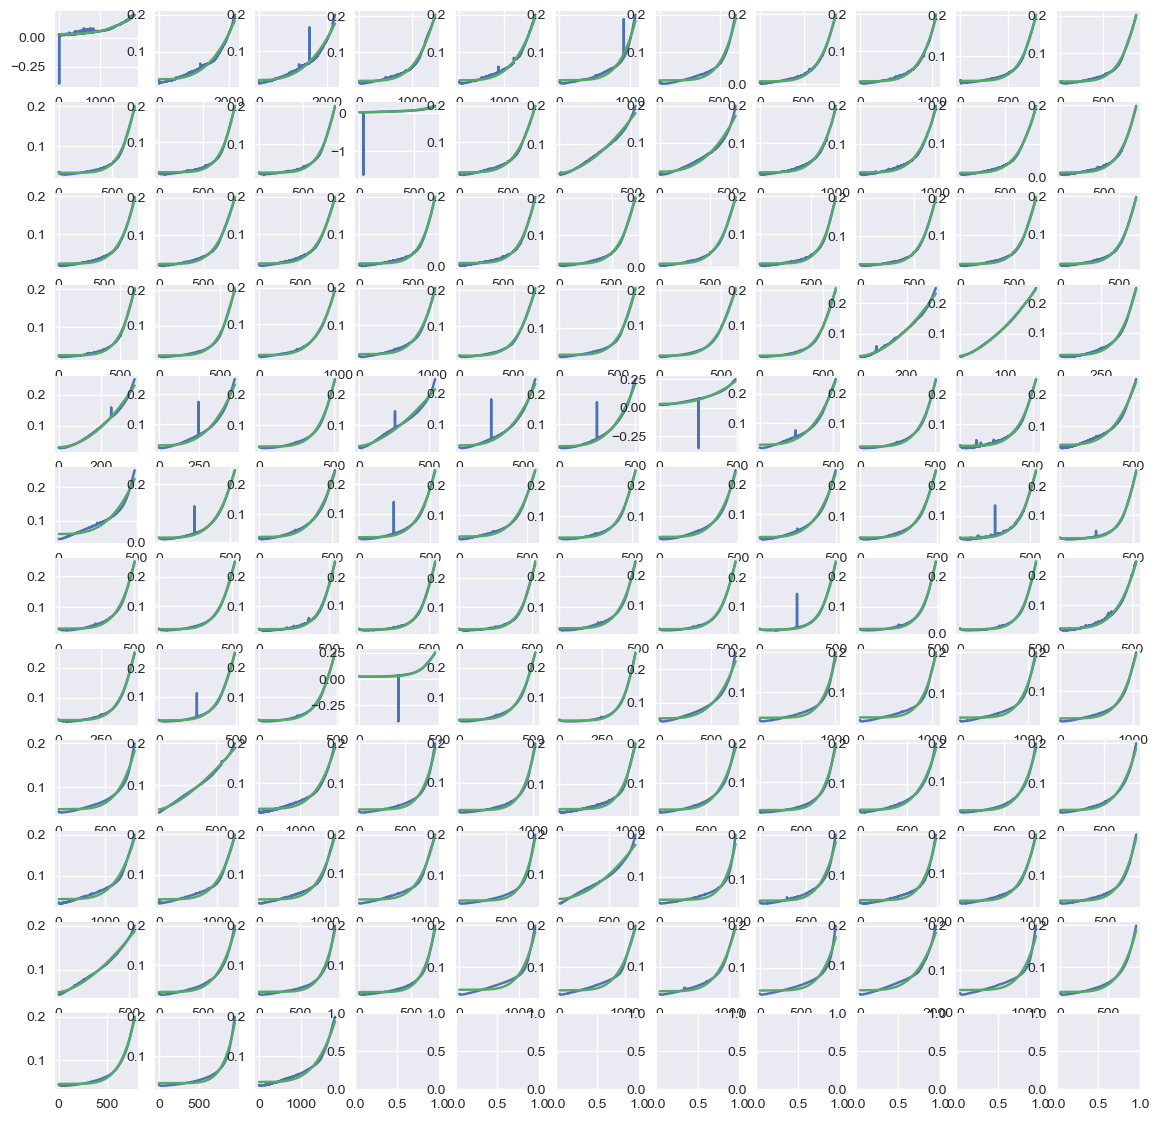

In [5]:
# visualize curve fits
fig,axs=plt.subplots(nrows=12,ncols=11,figsize=(14,14))
for ix,id in enumerate(bat_dict.keys()):
    ax = axs[int(ix/11)][ix%11]
    length = len(bat_dict[id]['summary']['QD'][1:])
    x = np.arange(1,length+1)
    Y = 1-bat_dict[id]['summary']['QD'][1:]/1.1
    ax.plot(x, Y)

    alpha = params[ix][0]
    beta = params[ix][1]
    gamma = params[ix][2]
    ax.plot(x, func(x,alpha,beta,gamma), linestyle="-")

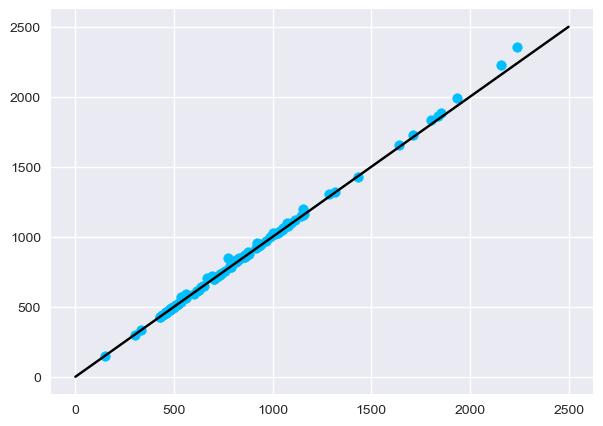

In [6]:
# visualize cycle life from fit curves vs. true cycle lives
fig,ax=plt.subplots(figsize=(7,5))
ax.scatter(true_cycle_lives,fit_cycle_lives,color="deepskyblue")
ax.plot(np.linspace(0,2500),np.linspace(0,2500),color="black")

## Functions for training

In [5]:
test_ind = np.array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
       34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
       68, 70, 72, 74, 76, 78, 80, 82, 83])

train_ind = np.array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
       69, 71, 73, 75, 77, 79, 81])

secondary_ind = np.array([ 84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122])

In [6]:
def prep_data(settings, params, true_cycle_lives, fit_cycle_lives):
    data = np.loadtxt(settings["input_file"],delimiter=',',skiprows=1) # skip row for column names

    x_train = data[:,settings["input_indices"]][train_ind]
    y_train = params[train_ind]
    true_life_train = true_cycle_lives[train_ind]
    fit_life_train = fit_cycle_lives[train_ind]

    x_test = data[:,settings["input_indices"]][test_ind]
    y_test = params[test_ind]
    true_life_test = true_cycle_lives[test_ind]
    fit_life_test = fit_cycle_lives[test_ind]

    x_stest = data[:,settings["input_indices"]][secondary_ind]
    y_stest = params[secondary_ind]
    true_life_stest = true_cycle_lives[secondary_ind]
    fit_life_stest = fit_cycle_lives[secondary_ind]

    train = TensorDataset(torch.Tensor(x_train),torch.Tensor(y_train),torch.Tensor(true_life_train),torch.Tensor(fit_life_train))
    test = TensorDataset(torch.Tensor(x_test),torch.Tensor(y_test),torch.Tensor(true_life_test),torch.Tensor(fit_life_test))
    stest = TensorDataset(torch.Tensor(x_stest),torch.Tensor(y_stest),torch.Tensor(true_life_stest),torch.Tensor(fit_life_stest))

    return train,test,stest

In [7]:
class AttentionModel(torch.nn.Module):
    def __init__(self, d_model, feat_dim, n_cycle, vdim=1, num_heads=1, attn_model="softmax", beta=1, skip_connect=0):
        super(AttentionModel, self).__init__()
        '''d_model: embedding dimension; can be chosen independently of input data dimensions
           feat_dim: number of features in a cycle
           n_cycle: number of "cycles" outputted by the encoder / number of tokens, each of which has feat_dim features
           vdim: dimension of output, 1 for our regression problem
           num_heads: default 1
           attn_model: default softmax; code also supports batch normalized attention with keyword "batch_norm"
           beta: if using batch normalized attention, beta is the weight placed on the mean
           skip_connect: whether or not to add a skip connection. If 0, no skip connection. If 1, H=AV+B where B
           is a trainable projection of the input X. If 2, H=AV+V'''
        assert d_model % num_heads == 0, "Embedding dimension (d_model) must be divisible by number of attention heads (num_heads)."
        
        self.W_q = nn.Linear(feat_dim, d_model)
        self.W_k = nn.Linear(feat_dim, d_model)
        self.W_v = nn.Linear(feat_dim, vdim)
        self.W_b = nn.Linear(feat_dim, vdim)

        self.create_output = nn.Linear(n_cycle,1) # final linear layer to collapse output

        self.d_model = d_model
        self.vdim = vdim
        self.num_heads = num_heads
        #self.head_dim = d_model // num_heads
        
        self.attn_model = attn_model
        self.beta = beta
        self.skip_connect = skip_connect

    def scaled_dot_product_attention(self, Q, K, V, B): 
        '''softmax attention'''
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_model // self.num_heads)
        attn_probs = torch.softmax(attn_scores, dim=-1) # attention matrix, dimensionality (batch size, n_cycle, n_cycle)
        output = torch.matmul(attn_probs, V) # dimensionality (batch size, n_cycle, vdim)
        if self.skip_connect == 1:
            output = output + B
        elif self.skip_connect == 2:
            output = output + V
        return output
    
    def batch_normalized_attention(self, Q, K, V, B):
        '''batch normalized attention'''
        mu = torch.mean(K,0)
        s = torch.std(K,0,correction=0)
        attn_scores = torch.matmul(torch.mul(Q-self.beta*mu,s), torch.mul(K-self.beta*mu,s).transpose(-2,-1)) / math.sqrt(self.d_model)
        attn_probs = torch.softmax(attn_scores, dim=-1) # attention matrix, dimensionality (batch size, batch size)
        output = torch.matmul(attn_probs, V)
        if self.skip_connect == 1:
            output = output + B
        elif self.skip_connect == 2:
            output = output + V
        return output
    
    def forward(self, X):
        if len(X.size()) < 3:
            X = X[...,None] # add a feature dimension if there is none
        Q = self.W_q(X) # create query matrix, dimensionality (batch size, n_cycle, d_model)
        K = self.W_k(X) # create key matrix, dimensionality (batch size, n_cycle, d_model)
        V = self.W_v(X) # create value matrix, dimensionality (batch size, n_cycle, vdim)
        B = self.W_b(X) # create matrix for skip connection, dimensionality (batch size, n_cycle, vdim)

        # replaced final linear layer with just an averaging layer (gave better results earlier, can try putting linear layer back) 
        if self.attn_model=="softmax": attn_output = self.scaled_dot_product_attention(Q, K, V, B)
        elif self.attn_model=="batch_norm": attn_output = self.batch_normalized_attention(Q, K, V, B)
        # attn_output has dimensionality (batch_size, n_cycle, vdim)
        output = torch.mean(attn_output.transpose(-2,-1),dim=-1) # dimensionality (batch_size, vdim)
        #output = self.create_output(attn_output.transpose(-2,-1)) # dimensionality (batch size, 1, 1)
        return output

In [8]:
class weighted_MSELoss(nn.Module):
    '''calculates MSE of scaled/normalized parameters'''
    def __init__(self):
        super().__init__()
    def forward(self,inputs,targets,weights):
        return torch.mean( torch.mul(((inputs - targets)**2 ), weights) )

In [9]:
def predict_error(settings,model,train,test,stest):
    errors = []
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    for i,dataset in enumerate([train,test,stest]):
        predicted =[]
        labels = []
        for cell in dataset:
            input, label, true_life, _ = cell
            pred = model(input[None,:].to(device)).detach().numpy()[0]
            pred_life = np.power(np.exp(-pred[0])*(0.2-pred[2]),1/pred[1])

            predicted.append(pred_life)
            labels.append(true_life[0])

        errors.append(np.sqrt(np.mean(np.power(np.array(predicted)-np.array(labels),2))))
    return errors

In [10]:
def make_plots(settings,model,train,test,stest):
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    np.set_printoptions(suppress=True)

    fig, ax = plt.subplots(figsize=(7,5))
    if settings["illustrative"]: fig_curve,axs_curve=plt.subplots(nrows=12,ncols=11,figsize=(14,14))

    colors = ["blue","red","orange"]
    parameter_results = {0:[[], []], 1:[[], []], 2:[[], []]}
    ix = 0

    for i,dataset in enumerate([train,test,stest]):
        predicted =[]
        labels = []
        for cell in dataset:
            input, label, true_life, _ = cell
            pred = model(input[None,:].to(device)).detach().numpy()[0]
            pred_life = np.power(np.exp(-pred[0])*(0.2-pred[2]),1/pred[1])

            parameter_results[i][0].append(label.detach().numpy())
            parameter_results[i][1].append(pred)
            predicted.append(pred_life)
            labels.append(true_life[0])

            n = settings["n_points"]
            x = torch.Tensor(np.arange(1,n))
            fit_curve = torch.exp(label[0])*torch.pow(x*(true_life/n),label[1])+label[2]
            pred_curve = np.exp(pred[0])*np.power(x*(true_life/n),pred[1])+pred[2]

            # plot predicted vs. ground truth curves
            if settings["illustrative"]: 
                ax_curve = axs_curve[int(ix/11)][ix%11]
                ax_curve.plot(fit_curve.detach().numpy(), color="cornflowerblue")
                ax_curve.plot(pred_curve, color="lightcoral")
                ix+=1

        print(np.sqrt(np.mean(np.power(np.array(predicted)-np.array(labels),2))))
        ax.plot(labels, predicted, ".",color=colors[i])
        ax.set_xlabel("Truth")
        ax.set_ylabel("Predicted")

    # plot predicted vs. actual cycle lives
    ax.plot(np.linspace(250,2250),np.linspace(250,2250),color="black")
    ax.set_ylim([0,2500])
    ax.set_title("Battery Life Predictions",fontweight="semibold")

    legend_elements = [Patch(facecolor='blue', label='Train'),
                    Patch(facecolor='red', label='Test'),
                    Patch(facecolor='orange', label='Secondary test')]
    ax.legend(handles=legend_elements)
    plt.show()

    if settings["illustrative"]: 
        # plot predicted vs. ground truth model parameters
        for i in range(3):
            parameter_results[i][0] = np.array(parameter_results[i][0])
            parameter_results[i][1] = np.array(parameter_results[i][1])

        plt.rcParams["figure.figsize"] = (18, 5)
        fig, axs = plt.subplots(1, 3)
        for i, title in zip(range(3), ["a", "b", "c"]):
            axs[i].set_title(title)
            for j, lab in zip(range(3), ["train", "test", "secondary"]):
                axs[i].plot(parameter_results[j][0][:, i], parameter_results[j][1][:, i], ".", label = lab)
                axs[i].set_xlabel("True")
                axs[i].set_ylabel("Predicted")
            axs[i].legend()
        plt.show()

## Run model with chosen settings

In [45]:
settings = {"input_file": "./../Data/features5.csv", # name of file with input data
            "input_indices": [1,2,3], # column indices of features to feed in
            "d_model": 2, "feat_dim": 1, "skip_connect": 0, "batch_size": 1, "attn_model": "softmax", # self-attention parameters
            "nepoch_coarse": 500, "nepoch_fine": 3000, # number of epochs for first and second training stages
            "lr_coarse": 1e-3, "lr_fine": 1e-5, # learning rate for first and second training stages
            "curve_loss": True, "n_points": 100, "curve_weight": 0.125, # do we include diff bw curves in loss function?
            'weighted_points': True,
            "param_weights": torch.Tensor([0.05,1,210]), # do we vary how much to weight each parameter in loss? can use to normalize param magnitudes
            "verbose": True, "illustrative":True} 

In [46]:
train,test,stest = prep_data(settings,params,true_cycle_lives,fit_cycle_lives)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [50]:
def ensemble_train(settings,ensemble_size=5):
    avg_pred_error = []
    for i in range(ensemble_size):
        model = AttentionModel(d_model=settings["d_model"],feat_dim=settings["feat_dim"],n_cycle=len(settings["input_indices"]),
                            vdim=3,attn_model=settings["attn_model"],skip_connect=settings["skip_connect"])
        criterion = weighted_MSELoss().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=settings["lr_coarse"])

        model.train()
        # Training loop
        for i in range(settings["nepoch_coarse"]):
            total_loss_train = 0.0
            total_loss_test = 0.0
            total_loss_stest = 0.0

            train_batched = DataLoader(train,batch_size=settings["batch_size"],shuffle=True)
            test_batched = DataLoader(test,batch_size=1)
            stest_batched = DataLoader(stest,batch_size=1)

            for j,batch in enumerate(train_batched):
                optimizer.zero_grad()
                train_input, train_label, true_life, fit_life = batch
                output = model(train_input.to(device))
                
                loss = criterion(output,train_label,settings["param_weights"])

                if settings["curve_loss"]:
                    n = settings["n_points"] # number of points at which to calculate curve loss
                    x = torch.Tensor(np.arange(1,n+1))
                    fit_curve = torch.exp(train_label[:,0])*torch.pow(x*(true_life/n),train_label[:,1])+train_label[:,2]
                    pred_curve = torch.exp(output[:,0])*torch.pow(x*(true_life/n),output[:,1])+output[:,2]
                    # calc loss as a linear combination of difference between curves and MSE loss of parameters
                    if settings["weighted_points"]: point_weights = torch.Tensor(np.linspace(1,2,n))
                    else: point_weights = torch.Tensor(np.ones(n))
                    loss += settings["curve_weight"]*criterion(fit_curve,pred_curve,point_weights)

                total_loss_train += loss.item()

                loss.backward()
                optimizer.step()

            rmse_train = np.sqrt(total_loss_train / (j+1))
            if (i+1)%50 == 0 and settings["verbose"]: 
                print(f'Epochs: {i + 1} | rmse: {rmse_train: .3f}')

        if settings["illustrative"]: make_plots(settings,model,train,test,stest)

        pred_error = predict_error(settings,model,train,test,stest)
        avg_pred_error.append(pred_error)
    avg_pred_error = np.mean(avg_pred_error,axis=0)
    return avg_pred_error, model

Epochs: 50 | rmse:  3.620
Epochs: 100 | rmse:  2.280
Epochs: 150 | rmse:  1.583
Epochs: 200 | rmse:  1.175
Epochs: 250 | rmse:  1.049
Epochs: 300 | rmse:  1.004
Epochs: 350 | rmse:  0.982
Epochs: 400 | rmse:  0.970
Epochs: 450 | rmse:  0.966
Epochs: 500 | rmse:  0.966
207.7214127649939
246.08895534535426
230.25745541576788


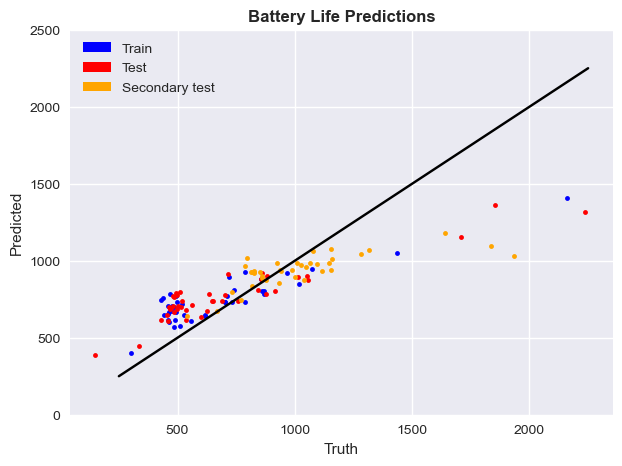

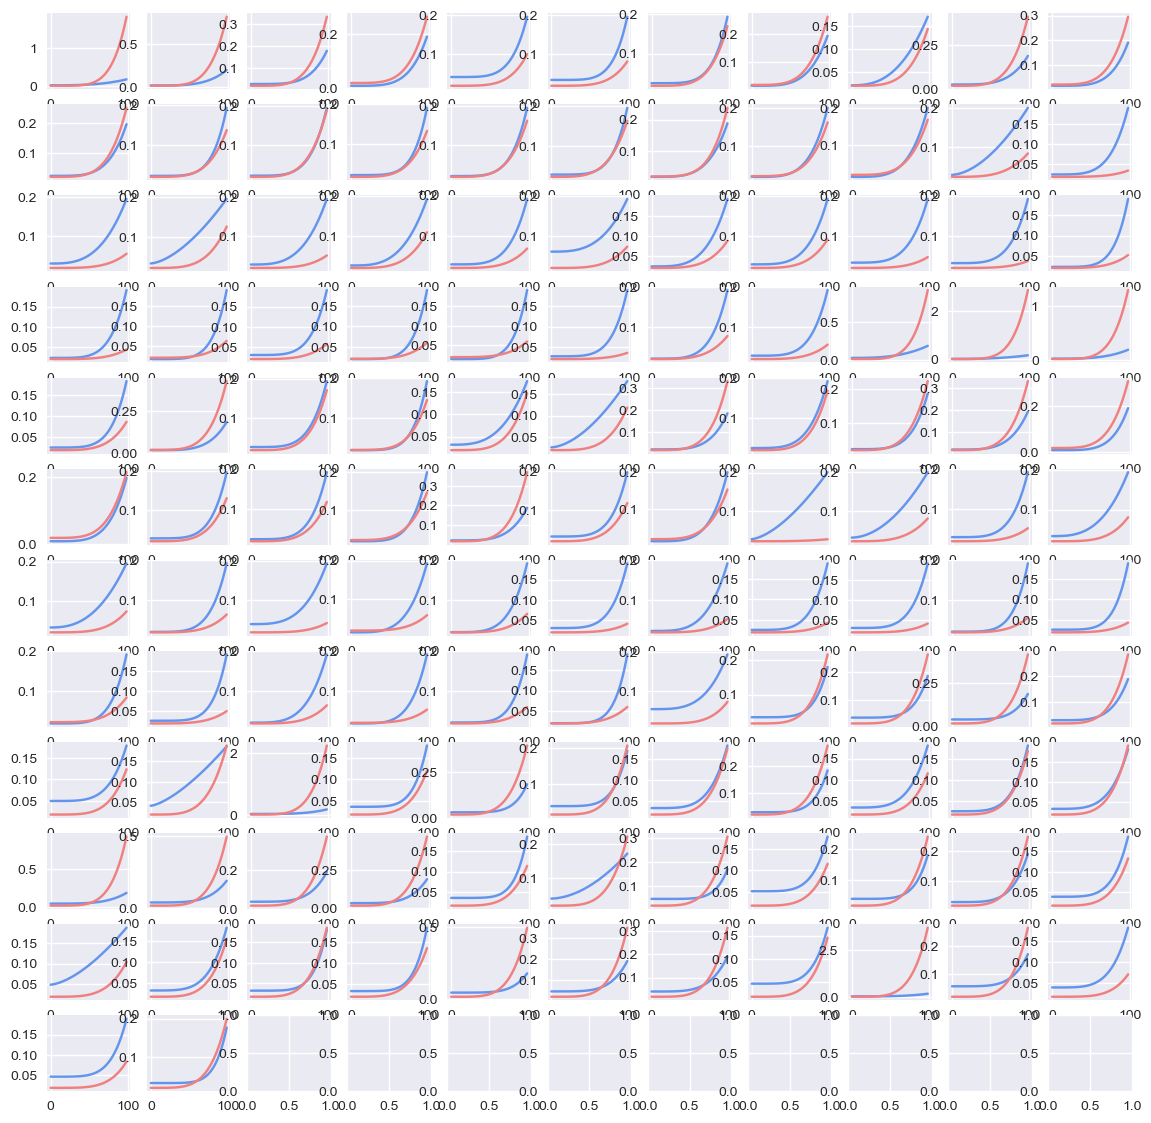

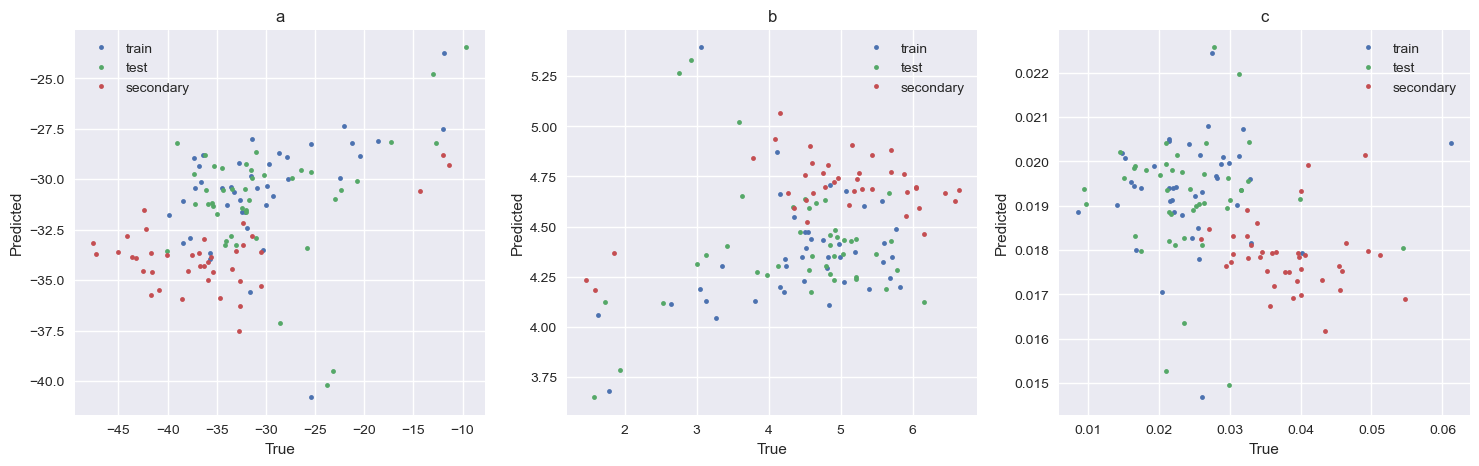

In [51]:
_, model = ensemble_train(settings,ensemble_size=1)

## Second round of training (calc loss w/ cycle lifetime)

In [77]:
# create a deep copy of model to fine tune
model2 = copy.deepcopy(model)

In [78]:
# low learning rate and many epochs for fine-tuning
optimizer_fine = torch.optim.Adam(model2.parameters(), lr=settings["lr_fine"])
#criterion = nn.MSELoss().to(device)
criterion = weighted_MSELoss().to(device)
n_fine = 100 # number of points at which to compare predicted curve with fitted curve
x_fine = torch.Tensor(np.arange(1,n_fine+1))
life_weight = 0.005

In [79]:
model2.train()

# Training loop
for i in range(settings["nepoch_fine"]):
    total_loss_train = 0.0
    total_loss_test = 0.0
    total_loss_stest = 0.0

    train_batched = DataLoader(train,batch_size=settings["batch_size"],shuffle=True)
    test_batched = DataLoader(test,batch_size=1)
    stest_batched = DataLoader(stest,batch_size=1)

    for j,batch in enumerate(train_batched):
        optimizer_fine.zero_grad()
        train_input, train_label, true_life, fit_life = batch
        output = model2(train_input.to(device))

        # calculate lifetime using closed-form equation
        pred_life = torch.pow(torch.exp(-output[:,0])*(0.2-output[:,2]),1/output[:,1])
        fit_life = torch.pow(torch.exp(-train_label[:,0])*(0.2-train_label[:,2]),1/train_label[:,1])
        #if torch.isnan(pred_life): 
        #    print(output)
        #    break

        fit_curve = torch.exp(train_label[:,0])*torch.pow(x_fine*(true_life/n_fine),train_label[:,1])+train_label[:,2]
        pred_curve = torch.exp(output[:,0])*torch.pow(x_fine*(true_life/n_fine),output[:,1])+output[:,2]
        loss = criterion(fit_curve,pred_curve,torch.Tensor(np.linspace(1,2,n_fine))) + life_weight*criterion(fit_life,pred_life,torch.Tensor([1]))

        #loss = criterion(output, train_label)
        #loss = criterion(pred_life,true_life)
        total_loss_train += loss.item()

        loss.backward()
        optimizer_fine.step()

    for cell in test_batched:
        test_input, test_label, true_life, fit_life = cell
        test_output = model2(test_input.to(device))
        #test_loss = criterion(test_output, test_label)
        pred_life = torch.pow(torch.exp(-test_output[:,0])*(0.2-test_output[:,2]),1/test_output[:,1])
        fit_life = torch.pow(torch.exp(-test_label[:,0])*(0.2-test_label[:,2]),1/test_label[:,1])

        fit_curve = torch.exp(test_label[:,0])*torch.pow(x_fine*(true_life/n_fine),test_label[:,1])+test_label[:,2]
        pred_curve = torch.exp(test_output[:,0])*torch.pow(x_fine*(true_life/n_fine),test_output[:,1])+test_output[:,2]
        test_loss = criterion(fit_curve,pred_curve,torch.Tensor(np.linspace(1,2,n_fine))) + life_weight*criterion(fit_life,pred_life,torch.Tensor([1]))
        #test_loss = criterion(pred_life,true_life)

        total_loss_test += test_loss.item()

    for cell in stest_batched:
        stest_input, stest_label, true_life, fit_life = cell
        stest_output = model2(stest_input.to(device))
        #stest_loss = criterion(stest_output, stest_label)

        pred_life = torch.pow(torch.exp(-stest_output[:,0])*(0.2-stest_output[:,2]),1/stest_output[:,1])
        fit_life = torch.pow(torch.exp(-stest_label[:,0])*(0.2-stest_label[:,2]),1/stest_label[:,1])

        fit_curve = torch.exp(stest_label[:,0])*torch.pow(x_fine*(true_life/n_fine),stest_label[:,1])+stest_label[:,2]
        pred_curve = torch.exp(stest_output[:,0])*torch.pow(x_fine*(true_life/n_fine),stest_output[:,1])+stest_output[:,2]
        stest_loss = criterion(fit_curve,pred_curve,torch.Tensor(np.linspace(1,2,n_fine))) + life_weight*criterion(fit_life,pred_life,torch.Tensor([1]))
        #stest_loss = criterion(pred_life,true_life)
        
        # print(i, output, train_label, loss)
        total_loss_stest += stest_loss.item()

    rmse_train = np.sqrt(total_loss_train / (j+1))
    rmse_test = np.sqrt(total_loss_test / len(test))
    rmse_stest = np.sqrt(total_loss_stest / len(stest))
    #wandb.log({"Epoch": i+1, "RMSE_train": rmse_train, "RMSE_test": rmse_test, "RMSE_stest": rmse_stest})
    if (i+1)%100 == 0: 
        print(f'Epochs: {i + 1} | rmse: {rmse_train: .3f} | rmse_test: {rmse_test: .3f} | rmse_stest: {rmse_stest: .3f}')

123.29452864917147
138.66735712514338
189.1486740058624


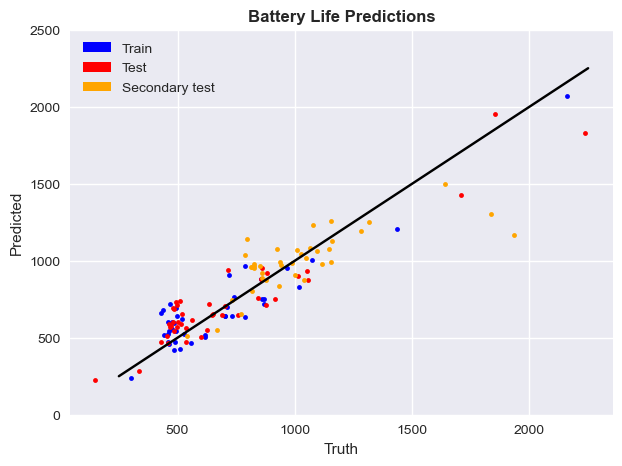

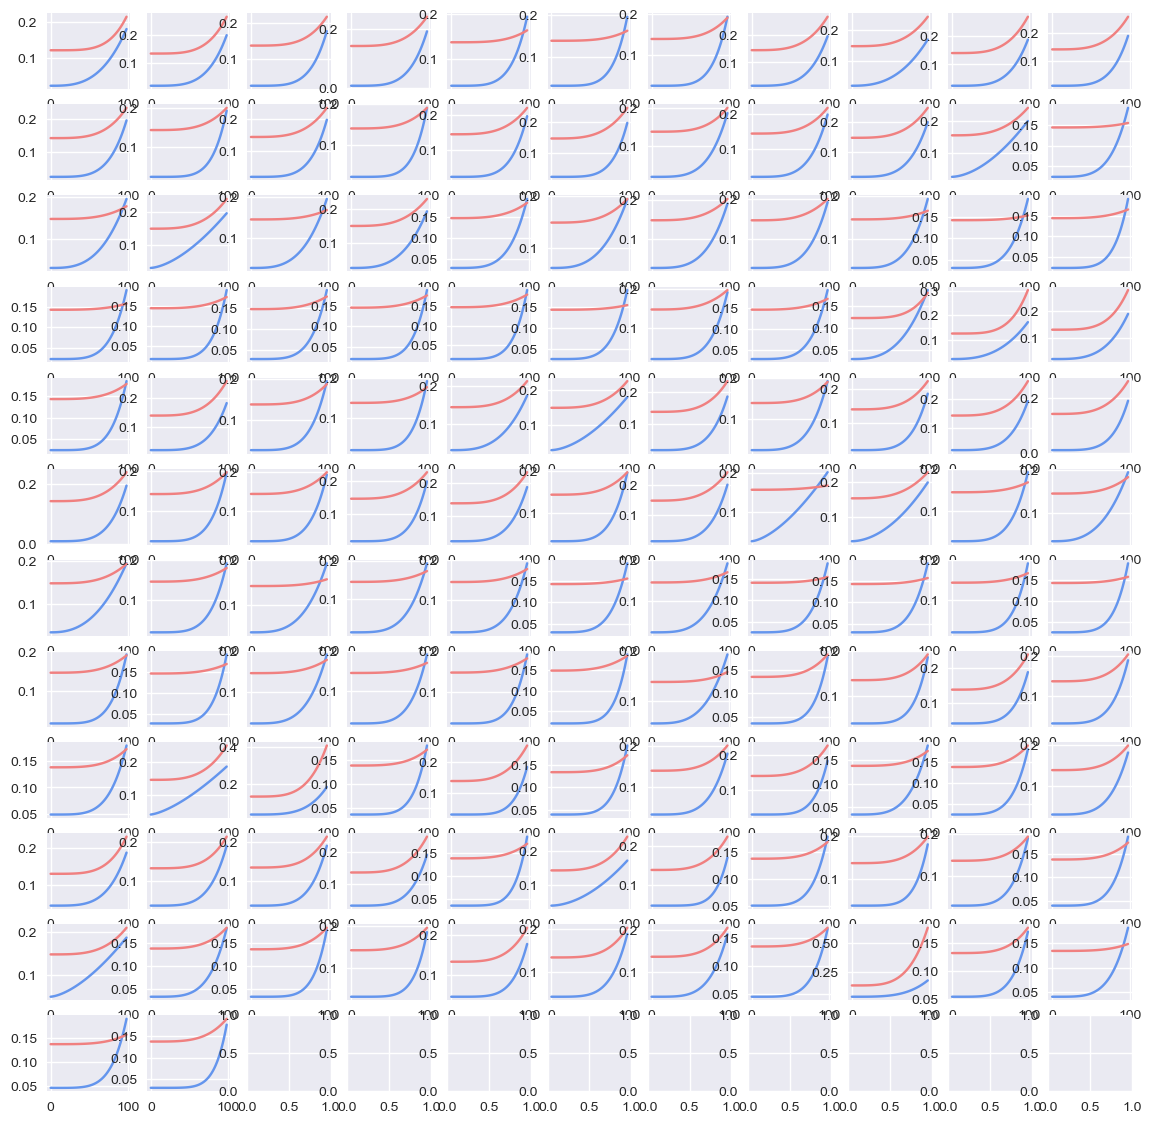

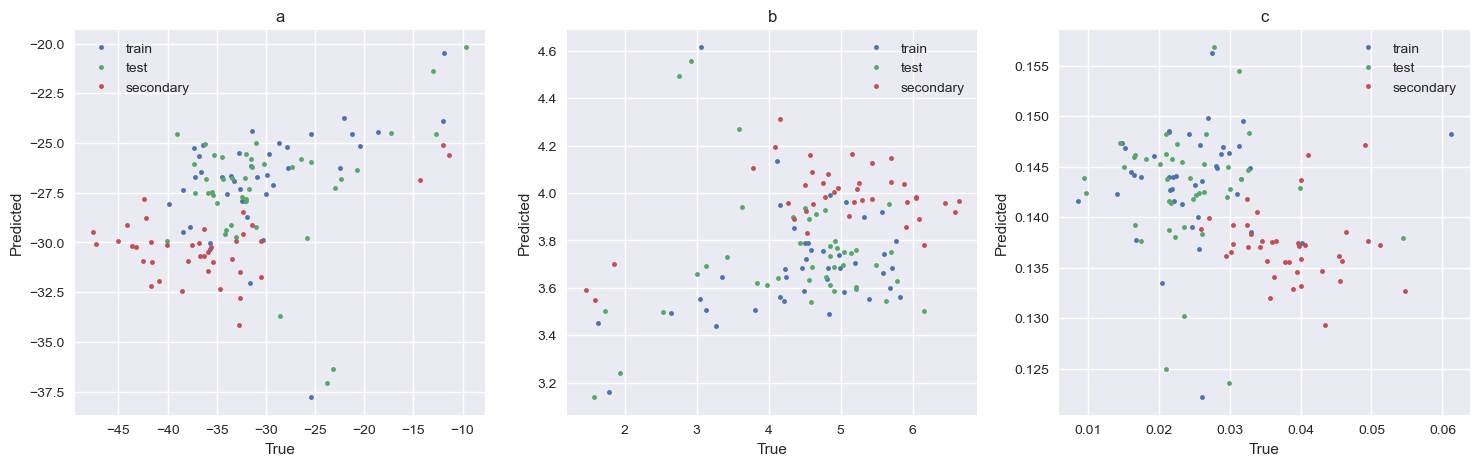

In [76]:
make_plots(settings,model2,train,test,stest)